# Building a Dictionary from PNAS Data
### Michael Frasco

##### Preliminaries

In [35]:
import json
import string
from bs4 import BeautifulSoup
from operator import itemgetter
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [36]:
articles = sc.textFile("s3n://stat-37601/pnas.json").map(lambda x: json.loads(x))

##### Parsing the Document

In [37]:
# Input: a string of XML obtained from the body of each PNAS document
# Output: a string of ascii text that is normalized
        # lower case and no punctuation
def parseXML(xmlString):
    textString = BeautifulSoup(xmlString).get_text()
    textString = textString.encode('ascii', 'ignore')
    textString = string.replace(textString, '\n', ' ')
    textString = textString.lower()
    textString = textString.translate(string.maketrans("",""), string.punctuation)
    return textString

In [38]:
# Input: The result from the function parseXML
# Output: A list of tuples with the word and a counter for that word
def getWords(textString):
    textWords = textString.split(' ')
    wordCounts = [(word, 1) for word in textWords if word != '']
    return wordCounts

In [39]:
# I chose to ignore the text in the title of the document.
# The number of words in the title is insignificant compared
# to the number of words in the body.
parsedStrings = articles.map(lambda x: parseXML(x['body']))

In [40]:
wordCounts = parsedStrings.flatMap(getWords)

In [41]:
summedCounts = wordCounts.reduceByKey(lambda x, y: x+y)

In [8]:
# This takes 10 minutes to run with 10 r.3large slaves
# vocabList = summedCounts.collect()

If you do not want to run the code above, I figured that a good alternative would be
to filter out extremely rare words before I collected the words as a list
the reason I need the list is so that I can use matplotlib to plot the frequencies. I implemented this approach in the code below.

In [42]:
filteredCounts = summedCounts.filter(lambda x: x[1] > 40)
vocabList2 = filteredCounts.collect()

After testing the results with this pre-filtered vocab list, I found that the plots do not change substantially. The number of words plotted is greater with the first solution, but the frequency of those words is not significant. The computation time is slightly better with this second solution, so that is the one that I will implement.

##### Analyzing Distribution of Words

In [43]:
sortedVocab = sorted(vocabList2, key=itemgetter(1), reverse=True)

In [44]:
frequencies = [wordCount[1] for wordCount in sortedVocab]

In [45]:
ranks = range(1, len(frequencies) + 1)

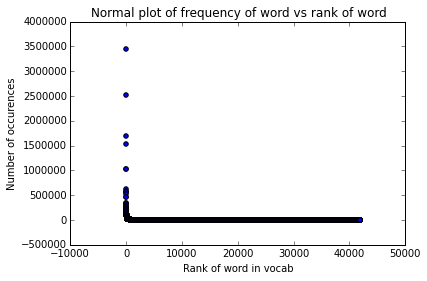

In [46]:
plt.scatter(ranks, frequencies)
plt.title("Normal plot of frequency of word vs rank of word")
plt.xlabel("Rank of word in vocab")
plt.ylabel("Number of occurences")
plt.show()

The plot above looks as if an error occured while plotting. However, this is the correct plot. The problem is that the scales of the x-axis and y-axis are so large that the plot os very distorted. We see from this plot that the most frequent word occurs 3.5 million times. We also see that there are 2 million unique words in the vocabulary. However, the vast majority of words occur with a frequency so small compared to the frequency of the first word that the graph looks like this.

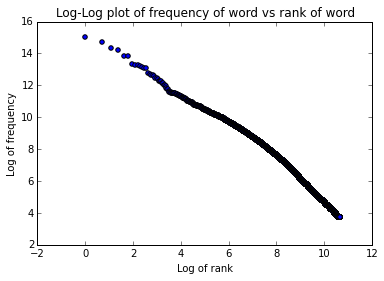

In [47]:
plt.scatter(np.log(ranks), np.log(frequencies))
plt.title("Log-Log plot of frequency of word vs rank of word")
plt.xlabel("Log of rank")
plt.ylabel("Log of frequency")
plt.show()

In this plot, we plot the log of the frequency versus the log of the rank of a word. By applying these transformations, we remove the scaling issues that we encountered in the previous plot. Remarkably, the data have a linear relationship on the log-log scale. Such a linear relationship is strong evidence that the data follow Zipf's law. Note that the linear relationship appears weakest at the tails.

##### Zipf's Law

Zipf's law states that given some corpus of natural language words, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc.

In [48]:
# The count of the most frequent word
N = float(sortedVocab[0][1])

In [54]:
# Some ranks with which to test the application of Zipf's law to this distribution
testRanks = [2, 3, 5, 10, 25, 100, 1000, 10000, 40000]

In [55]:
PredictionVsObserved = [(round(N / k), sortedVocab[k][1]) for k in testRanks]

In [56]:
print PredictionVsObserved

[(1723719.0, 1696140), (1149146.0, 1526594), (689487.0, 1029692), (344744.0, 515043), (137897.0, 190391), (34474.0, 47559), (3447.0, 7113), (345.0, 349), (86.0, 44)]


In the above list, the first element of each tuple is the predicted frequency of the word of a given rank and the second element of the tuple is the observed frequency. The predicted and observed values are not always equal, but they are of the correct order of magnitude. Part of the discrepency has to do with the choosing of the first word as the basis for the predictions. However, the other reason might be that this corpus of text is not entirely representative of the enlish language, since it comes from strictly scientific articles.

##### Pruning the vocabulary

Before pruning there are almost 2 million words in my vocabulary. I want to reduce that size to around 50,000 by removing stop words and exceptionally rare words.

In [18]:
# sortedVocab = sortedVocab[0:50000] this is only necessary with the first solution

In [57]:
stopWords = ['a','able','about','across','after','all','almost','also','am',
             'among','an','and','any','are','as','at','be','because','been',
             'but','by','can','cannot','could','dear','did','do','does',
             'either','else','ever','every','for','from','get','got','had',
             'has','have','he','her','hers','him','his','how','however','i',
             'if','in','into','is','it','its','just','least','let','like',
             'likely','may','me','might','most','must','my','neither','no',
             'nor','not','of','off','often','on','only','or','other','our',
             'own','rather','said','say','says','she','should','since','so',
             'some','than','that','the','their','them','then','there','these',
             'they','this','tis','to','too','twas','us','wants','was','we',
             'were','what','when','where','which','while','who','whom','why',
             'will','with','would','yet','you','your']

In [58]:
pnasvocab = [word[0] for word in sortedVocab if word[0] not in stopWords]

In [59]:
pnasvocab[0:10]

['cells',
 'fig',
 'cell',
 'protein',
 'b',
 'expression',
 'shown',
 'dna',
 'two',
 'gene']

Hahah. We can tell this is a very scientific because cells is the most common word after removing stop words.

In [60]:
with open('pnasvocab.txt', 'wb') as f:
    for word in pnasvocab:
        f.write(word + '\n')

I have attached this file on chalk.